In [17]:
import tensorflow as tf
import ctypes
import gmpy2
from gmpy2 import mpz
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation, Dense
from keras.layers import Flatten, Reshape
from keras.layers import Conv1D
from keras.layers import concatenate
from keras.optimizers import Adam, RMSprop
from keras.models import load_model
K.clear_session()
kersize = 4

In [18]:
model_name = 'ANC'

#the standard parameters: message, key, and ciphertext bit lengths
m_bits = 8
k_bits = 8
c_bits = 8
pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits + k_bits)

alice_file = 'models/crypto/' + model_name + '-alice_complex'
bob_file = 'models/crypto/' + model_name + '-bob_complex'
eve_file = 'models/crypto/' + model_name + '-eve_complex'

In [19]:
#### Alice network ####

# Define inputs
alice_input0 = Input(shape=(m_bits,))  # Message
alice_input1 = Input(shape=(k_bits,))  # Key
alice_input = concatenate([alice_input0, alice_input1], axis=1)

# Concatenate inputs
alice_concat = concatenate([alice_input0, alice_input1], axis=1)

# Dense layer
alice_dense1 = Dense(units=(m_bits + k_bits))(alice_concat)
alice_dense1a = Activation('tanh')(alice_dense1)

# Reshape
alice_reshape = Reshape((m_bits + k_bits, 1,))(alice_dense1a)

# Convolutional layers
alice_conv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(alice_reshape)
alice_conv1a = Activation('tanh')(alice_conv1)
alice_conv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(alice_conv1a)
alice_conv2a = Activation('tanh')(alice_conv2)
alice_conv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(alice_conv2a)
alice_conv3a = Activation('tanh')(alice_conv3)
alice_conv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(alice_conv3a)
alice_conv4a = Activation('tanh')(alice_conv4)

# Adding more convolutional layers
alice_conv5 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(alice_conv4a)
alice_conv5a = Activation('tanh')(alice_conv5)
alice_conv6 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(alice_conv5a)
alice_conv6a = Activation('tanh')(alice_conv6)

# Flatten
alice_flat = Flatten()(alice_conv6a)

# Dense layer for output
alice_output = Dense(units=c_bits, activation='tanh')(alice_flat)  # Ciphertext

# Create model
alice = Model([alice_input0, alice_input1], alice_output, name='alice')
alice.summary()


Model: "alice"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 16)                   0         ['input_1[0][0]',             
 )                                                                   'input_2[0][0]']             
                                                                                                  
 dense (Dense)               (None, 16)                   272       ['concatenate_1[0][0]']   

In [20]:
from keras.src.layers import Activation

# Define inputs
bob_input0 = Input(shape=(c_bits,))  # Ciphertext
bob_input1 = Input(shape=(k_bits,))  # Key
bob_input = concatenate([bob_input0, bob_input1], axis=1)

# Concatenate inputs
bob_concat = concatenate([bob_input0, bob_input1], axis=1)

# Dense layer
bob_dense1 = Dense(units=(c_bits + k_bits))(bob_concat)
bob_dense1a = Activation('tanh')(bob_dense1)

# Reshape
bob_reshape = Reshape((c_bits + k_bits, 1,))(bob_dense1a)

# Convolutional layers
bob_conv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bob_reshape)
bob_conv1a = Activation('tanh')(bob_conv1)
bob_conv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bob_conv1a)
bob_conv2a = Activation('tanh')(bob_conv2)
bob_conv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bob_conv2a)
bob_conv3a = Activation('tanh')(bob_conv3)
bob_conv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bob_conv3a)
bob_conv4a = Activation('tanh')(bob_conv4)

# Adding more convolutional layers
bob_conv5 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bob_conv4a)
bob_conv5a = Activation('tanh')(bob_conv5)
bob_conv6 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bob_conv5a)
bob_conv6a = Activation('tanh')(bob_conv6)

# Flatten
bob_flat = Flatten()(bob_conv6a)

# Dense layer for output
bob_output = Dense(units=m_bits, activation='sigmoid')(bob_flat)  # Decrypted message

# Create model
bob = Model([bob_input0, bob_input1], bob_output, name='bob')
bob.summary()

Model: "bob"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 concatenate_3 (Concatenate  (None, 16)                   0         ['input_3[0][0]',             
 )                                                                   'input_4[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 16)                   272       ['concatenate_3[0][0]']     

In [21]:
#### Eve network ####
# Define inputs
eve_input = Input(shape=(c_bits,))  # Ciphertext only

# Dense layers
eve_dense1 = Dense(units=(c_bits + k_bits))(eve_input)
eve_dense1a = Activation('tanh')(eve_dense1)
eve_dense2 = Dense(units=(m_bits + k_bits))(eve_dense1a)
eve_dense2a = Activation('tanh')(eve_dense2)

# Reshape
eve_reshape = Reshape((m_bits + k_bits, 1,))(eve_dense2a)

# Convolutional layers
eve_conv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(eve_reshape)
eve_conv1a = Activation('tanh')(eve_conv1)
eve_conv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(eve_conv1a)
eve_conv2a = Activation('tanh')(eve_conv2)
eve_conv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(eve_conv2a)
eve_conv3a = Activation('tanh')(eve_conv3)
eve_conv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(eve_conv3a)
eve_conv4a = Activation('tanh')(eve_conv4)

# Adding more convolutional layers
eve_conv5 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(eve_conv4a)
eve_conv5a = Activation('tanh')(eve_conv5)
eve_conv6 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(eve_conv5a)
eve_conv6a = Activation('tanh')(eve_conv6)

# Flatten
eve_flat = Flatten()(eve_conv6a)

# Dense layer for output
eve_output = Dense(units=m_bits, activation='sigmoid')(eve_flat)  # Code break attempt

# Create model
eve = Model(eve_input, eve_output, name='eve')
eve.summary()

Model: "eve"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 activation_14 (Activation)  (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                272       
                                                                 
 activation_15 (Activation)  (None, 16)                0         
                                                                 
 reshape_2 (Reshape)         (None, 16, 1)             0         
                                                                 
 conv1d_12 (Conv1D)          (None, 16, 4)             20      

In [22]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')


In [23]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([alice_input0, alice_input1])
bobout = bob( [aliceout, bob_input1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher


eveloss = K.mean(  K.sum(K.abs(alice_input0 - eveout), axis=-1)  )


#
bobloss = K.mean(  K.sum(K.abs(alice_input0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

# Optimizer and compilation

abeoptim = Adam()
eveoptim = Adam()


# Build and compile the model, used for training Alice-Bob networks
#
abemodel = Model([alice_input0, alice_input1, bob_input1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([alice_input0, alice_input1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

In [24]:
abelosses = []
boblosses = []
evelosses = []
n_epochs = 30
batch_size = 256
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = [] #epoch-bound losses for text display during training
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 30 epochs with 256 batches of size 256
8/8 [==============================] - 0s 5ms/step

8/8 [==============================] - 0s 5ms/step

8/8 [==============================] - 0s 5ms/step

8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 5ms/step

8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 5ms/step

8/8 [==============================] - 0s 6ms/step

8/8 [==============================] - 0s 3ms/step

8/8 [==============================] - 0s 7ms/step

8/8 [==============================] - 0s 5ms/step

8/8 [==============================] - 0s 4ms/step

8/8 [==============================] - 0s 5ms/step

8/8 [==============================] - 0s 5ms/step

8/8 [==============================] - 0s 3ms/step

8/8 [==============================] - 0s 5ms/step

8/8 [==============================] - 0s 6ms/step

8/8 [==============================] - 0s 6ms/step

8/8 [=======

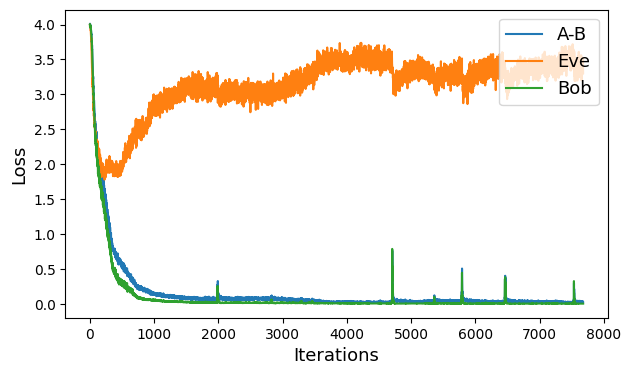

In [25]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B', alpha=0.99)
plt.plot(evelosses[:steps], label='Eve', alpha=0.99)
plt.plot(boblosses[:steps], label='Bob', alpha=0.99)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13, loc='upper right')

# plt.savefig("images/" + model_name + "-all.png", transparent=True) #dpi=100
plt.show()

In [26]:
alice.save(alice_file + '.h5', overwrite=False)
bob.save(bob_file + '.h5', overwrite=False)
eve.save(eve_file + '.h5', overwrite=False)

C:\Users\aatis\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
alice = load_model(alice_file + '.h5')
bob = load_model(bob_file + '.h5')
eve = load_model(eve_file + '.h5')

In [28]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])

m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

313/313 [==============================] - 2s 5ms/step
Bob % correct:  99.99 %
Eve % correct:  1.42 %


In [ ]:
# on increasing the complexity of the model it is evident that the accuracy of result increases.

more layers